# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import HybridModelPredictiveController
from pympc.approximated_controller_full_feasible_sets import ApproximatedHybridModelPredictiveController, PolicySampler, upload_PolicySampler
from pympc.geometry.polytope import Polytope

# Dynamics

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [3]:
m = 1.
l = 1.
g = 10.
k = 1000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$.

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.1
A_1 = np.array([[0., 1.],[g/l, 0.]])
B_1 = np.array([[0.],[1/(m*l**2.)]])
c_1 = np.array([[0.],[0.]])
S_1 = ds.AffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2
A_2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_2 = B_1
c_2 = np.array([[0.],[k*d/(m*l)]])
S_2 = ds.AffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state domain n.1
x_max_1 = np.array([[d/l], [1.]])
x_min_1 = -np.array([[d/l*1.2],[x_max_1[1,0]]])
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# state domain n.2
x_min_2 = np.array([[x_max_1[0,0]], [x_min_1[1,0]]])
x_max_2 = -x_min_1
X_2 = Polytope.from_bounds(x_min_2, x_max_2)
X_2.assemble()

# list of state domains
X = [X_1, X_2]

# input domain
u_max = np.array([[4.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*2

We can now define the PWA system.

In [6]:
pwa_sys = ds.PieceWiseAffineSystem.from_orthogonal_domains(S, X, U)

# MPC controller

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [7]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[0].A, S[0].B, Q, R)
X_N = ds.moas_closed_loop_from_orthogonal_domains(S[0].A, S[0].B, K, X[0], U[0])

# hybrid controller
gurobi_parameters = {'OutputFlag': False}
controller = HybridModelPredictiveController(pwa_sys, N, objective_norm, Q, R, P, X_N, gurobi_parameters)

Computation of Maximal Invariant Constraint-Admissible Set started.
Determinedness index: 23, Convergence index: -8.2567687914e-05, Number of facets: 120.                
Maximal Invariant Constraint-Admissible Set found.
Removing redundant facets ... minimal facets are 45.


We can now simulate the closed-loop dynamics startion from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[.05],[.52]])
u = []
x = [x_0]
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

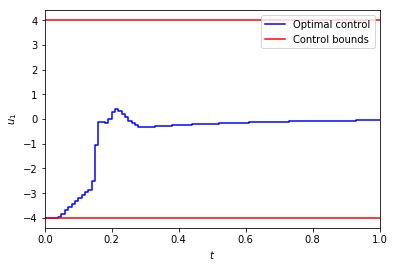

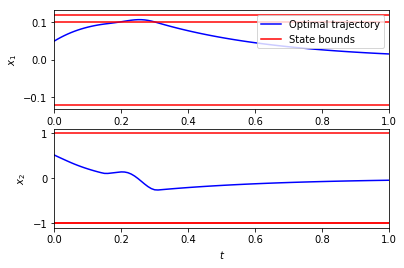

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

# Approximate MPC controller

Construction of the library

In [10]:
terminal_mode = 0
n_samples = 10000
sampler = PolicySampler(controller)
sampler.sample_policy(n_samples)
#library.save('library_pendulum_' + str(n_samples))

Sample 0: 
solving MIQP...  time spent: 0.00117707252502 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1: 
solving MIQP...  time spent: 0.00335001945496 s, model status: OPTIMAL.
condensing QP...  QP condensed in 0.00439405441284 s.
Sample 2: 
solving MIQP...  time spent: 0.00101900100708 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 3: 
solving MIQP...  time spent: 0.000893831253052 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 4: 
rejected.
Sample 5: 
rejected.
Sample 6: 
rejected.
Sample 7: 
rejected.
Sample 8: 
rejected.
Sample 9: 
rejected.
Sample 10: 
rejected.
Sample 11: 
rejected.
Sample 12: 
solving MIQP...  time spent: 0.00233817100525 s, model status: OPTIMAL.
condensing QP...  QP condensed in 0.00204920768738 s.
Sample 13: 
rejected.
Sample 14: 
rejected.
Sample 15: 
solving MIQP...  time spent: 0.00155591964722 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 16: 
rejected.
Sample 17: 
rejected.
Sample 18: 
solving MIQP...  time spent: 0.000801086425781 s, model s


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 7, vertices found so far 7, length of the last inflation 2.499700e-04.
Projection derived 0.320247173309 seconds: number of facets is 7, number of vertices is 7.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 68, vertices found so far 68, length of the last inflation 5.655983e-05.
Projection derived 3.65528988838 seconds: number of facets is 68, number of vertices is 68.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 12, vertices found so far 12, length of the last inflation 7.487556e-05.
Projection derived 0.588305950165 seconds:

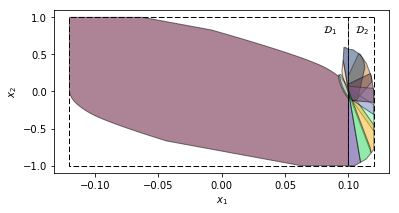

In [11]:
fig = plt.figure(figsize=(6,3))
X_1.plot(facecolor='w', linestyle='--')
plt.text(.08,.8,r'$\mathcal{D}_1$')
X_2.plot(facecolor='w', linestyle='--')
plt.text(.105,.8,r'$\mathcal{D}_2$')
sampler.plot_partition()
#fig.savefig('sample_pendulum.pdf', bbox_inches='tight')
plt.show()

In [60]:
from pympc.mode_sequence_tree import ModeSequenceTree
tree = ModeSequenceTree()
tree.expand(sampler.qp_library)

In [61]:
tree.plot()

In [117]:
x = np.array([[0.105],[0.5]])
tree.get_feasible_mode_sequences(x)

Mode sequence (0,) infeasible.
Mode sequence (1,) feasible.
Mode sequence (1, 0, 0, 0, 0, 0, 0, 0, 0, 0) infeasible.
Mode sequence (1, 1) feasible.
Mode sequence (1, 1, 0, 0, 0, 0, 0, 0, 0, 0) infeasible.
Mode sequence (1, 1, 1) feasible.
Mode sequence (1, 1, 1, 0, 0, 0, 0, 0, 0, 0) infeasible.
Mode sequence (1, 1, 1, 1) feasible.
Mode sequence (1, 1, 1, 1, 0, 0, 0, 0, 0, 0) infeasible.
Mode sequence (1, 1, 1, 1, 1) feasible.
Mode sequence (1, 1, 1, 1, 1, 0, 0, 0, 0, 0) infeasible.
Mode sequence (1, 1, 1, 1, 1, 1) feasible.
Mode sequence (1, 1, 1, 1, 1, 1, 0, 0, 0, 0) infeasible.
Mode sequence (1, 1, 1, 1, 1, 1, 1, 1) feasible.
Mode sequence (1, 1, 1, 1, 1, 1, 1, 1, 0, 0) infeasible.
Mode sequence (1, 1, 1, 1, 1, 1, 1, 1, 1, 1) feasible.


([(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)], 0.0021085739135742188)

In [116]:
from pympc.mode_sequence_tree import get_feasible_mode_sequences_inefficient
print get_feasible_mode_sequences_inefficient(sampler.qp_library, x)

([(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)], 0.0019047260284423828)
